In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
!{sys.executable} -m pip install QuantLib


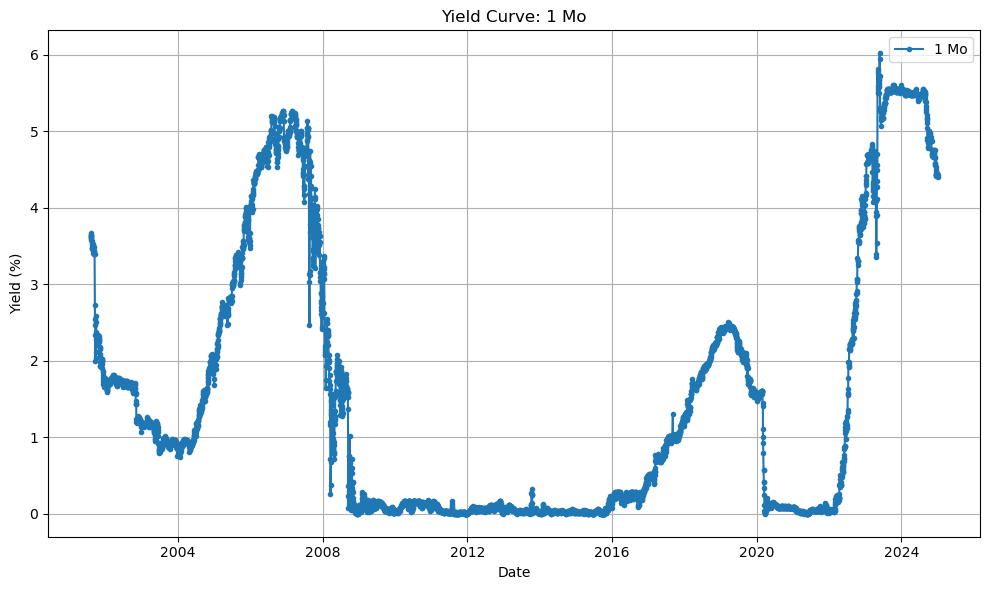

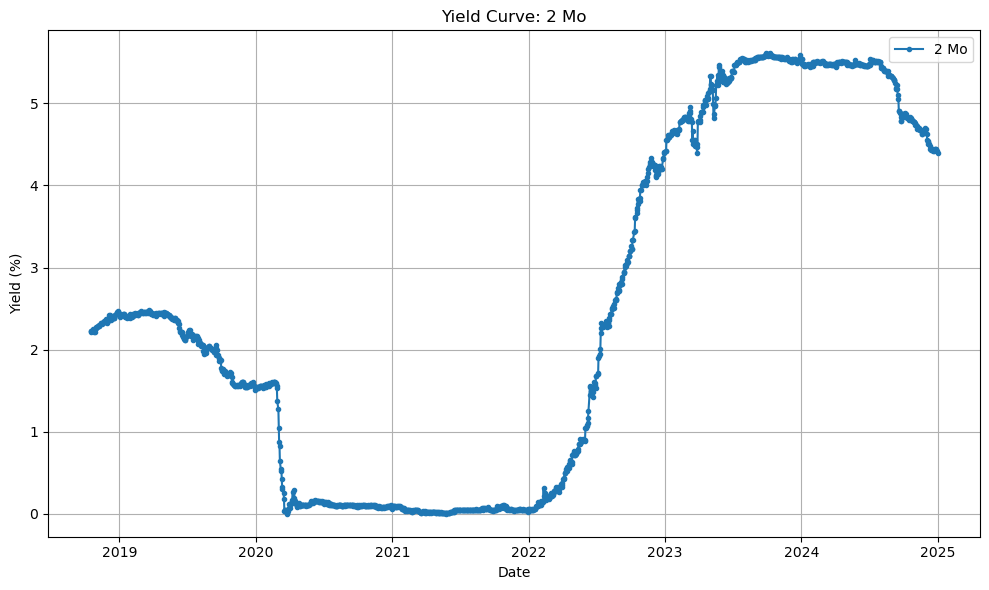

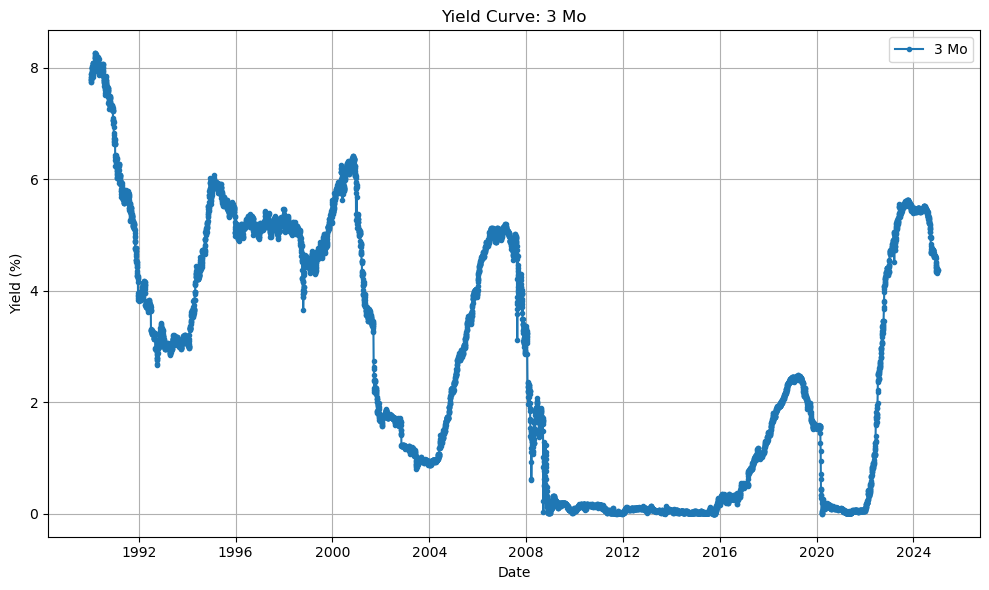

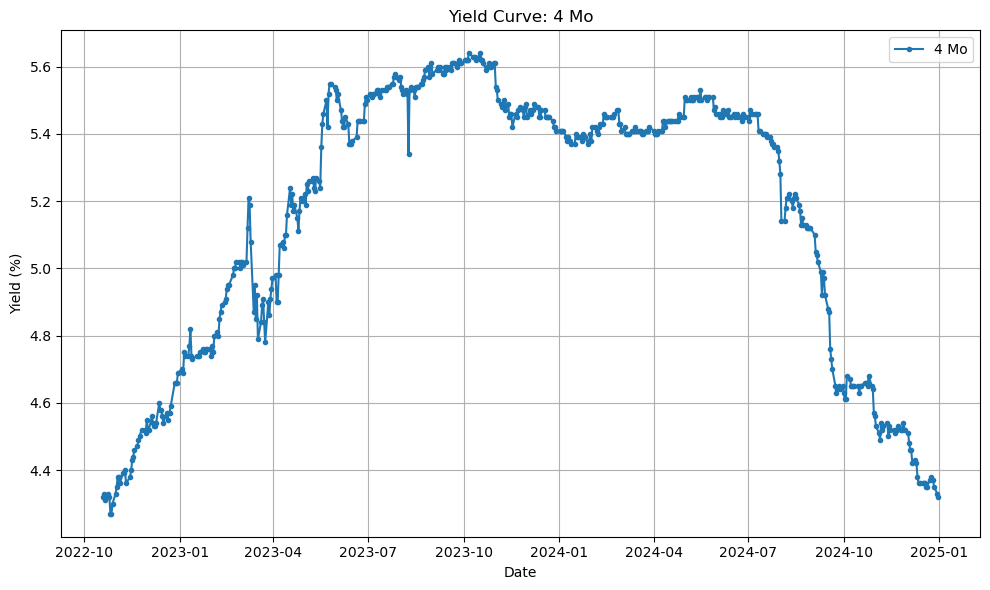

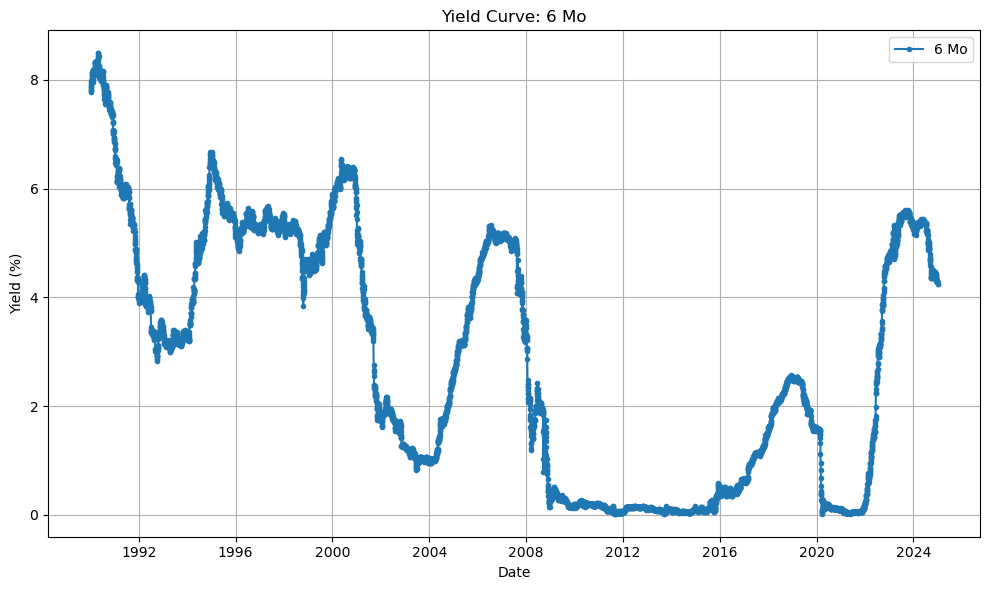

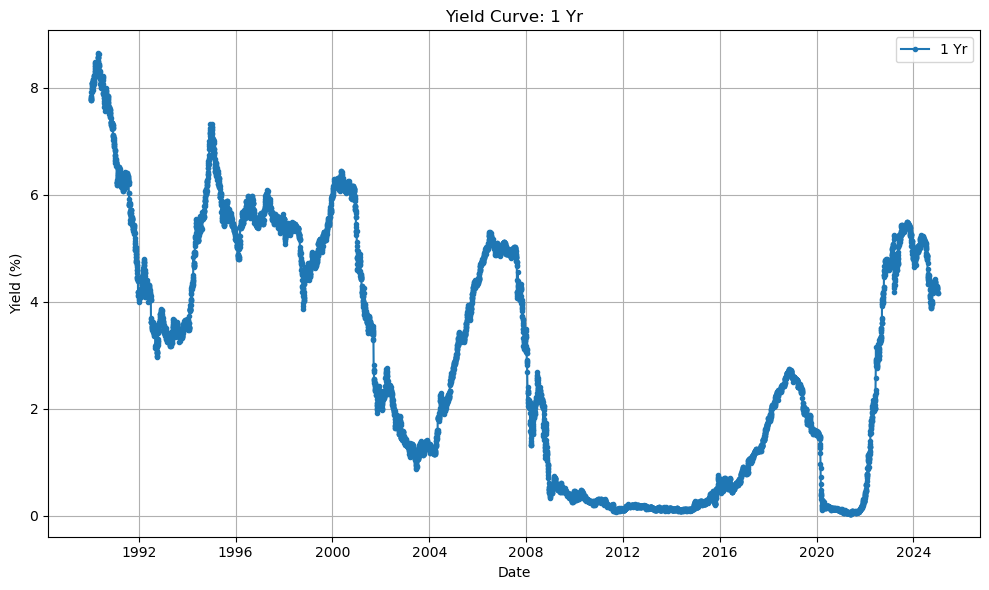

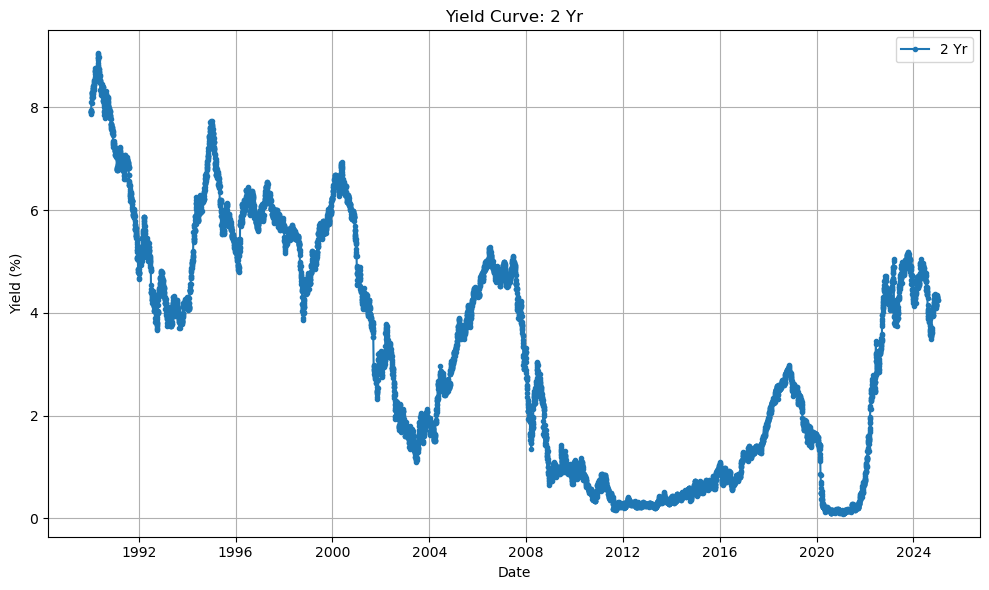

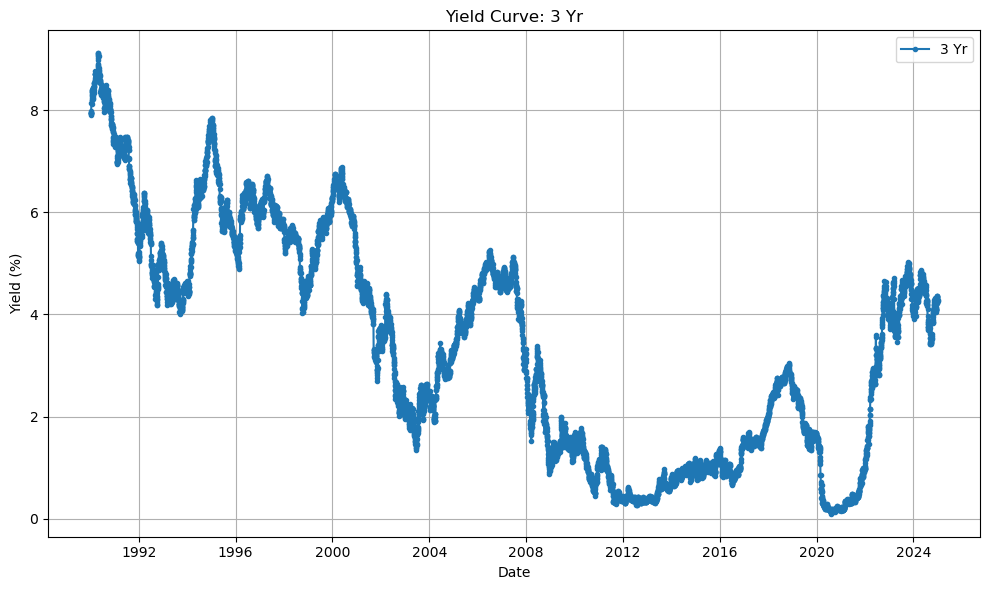

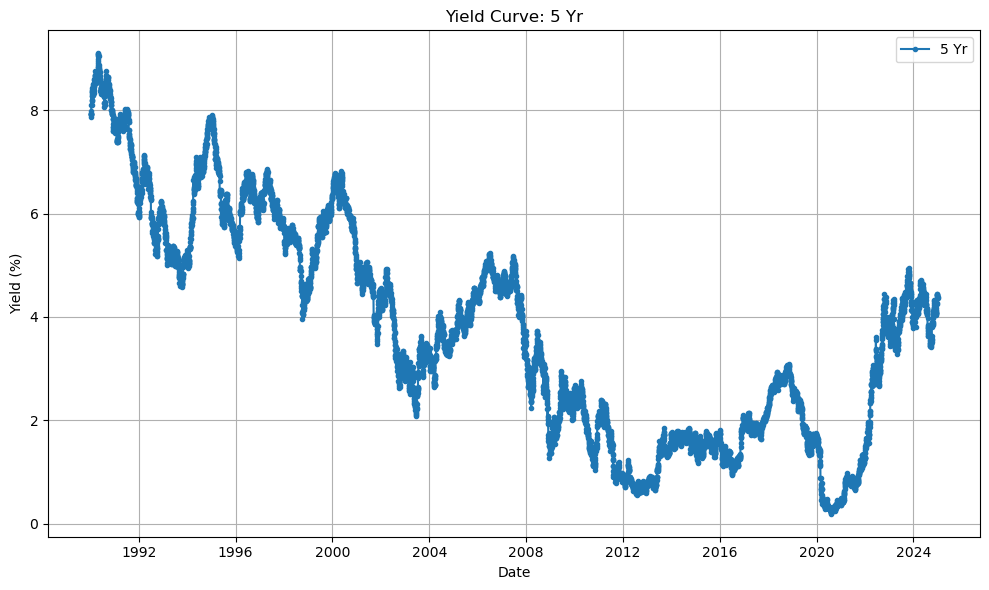

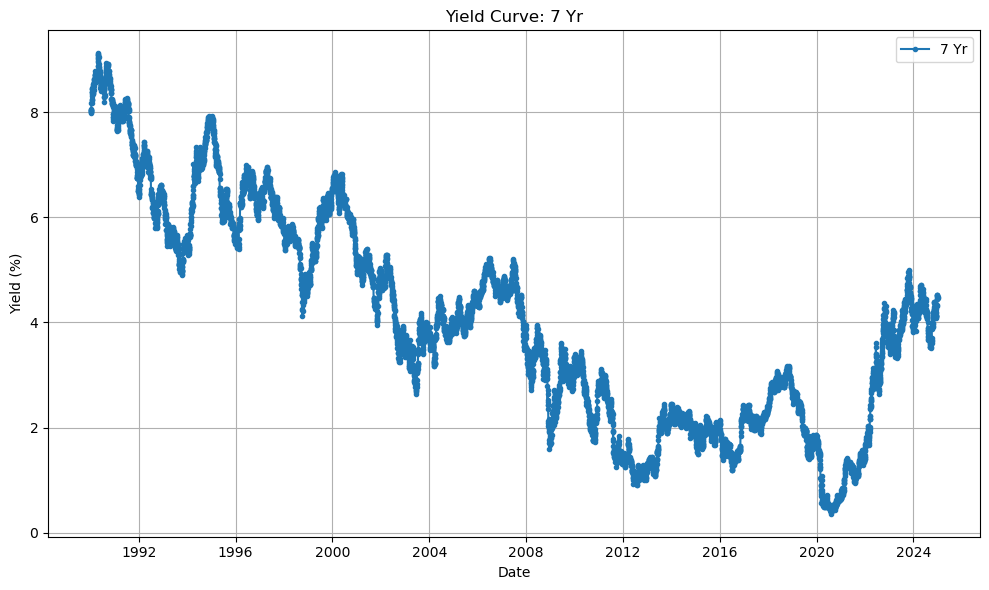

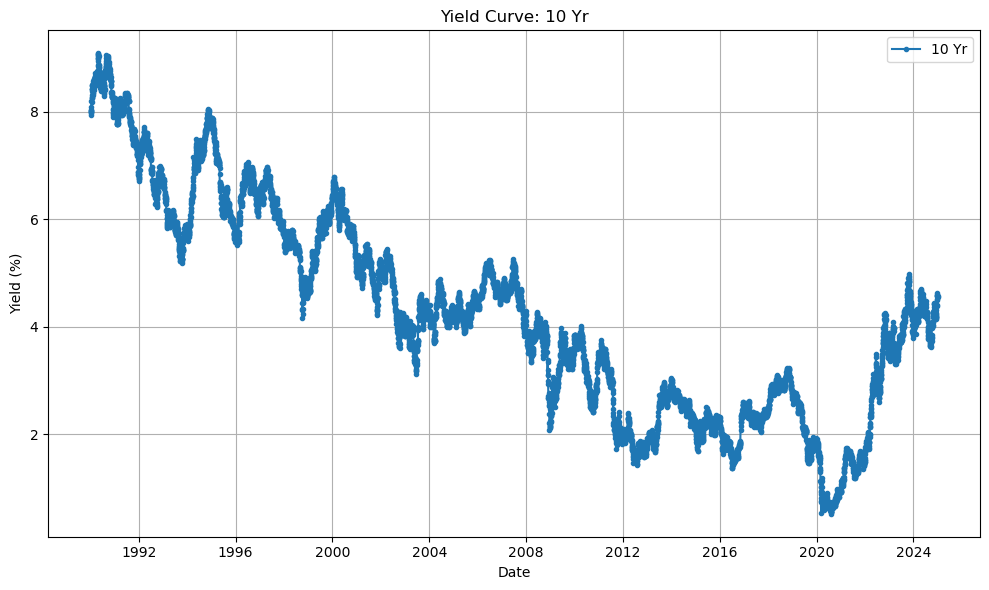

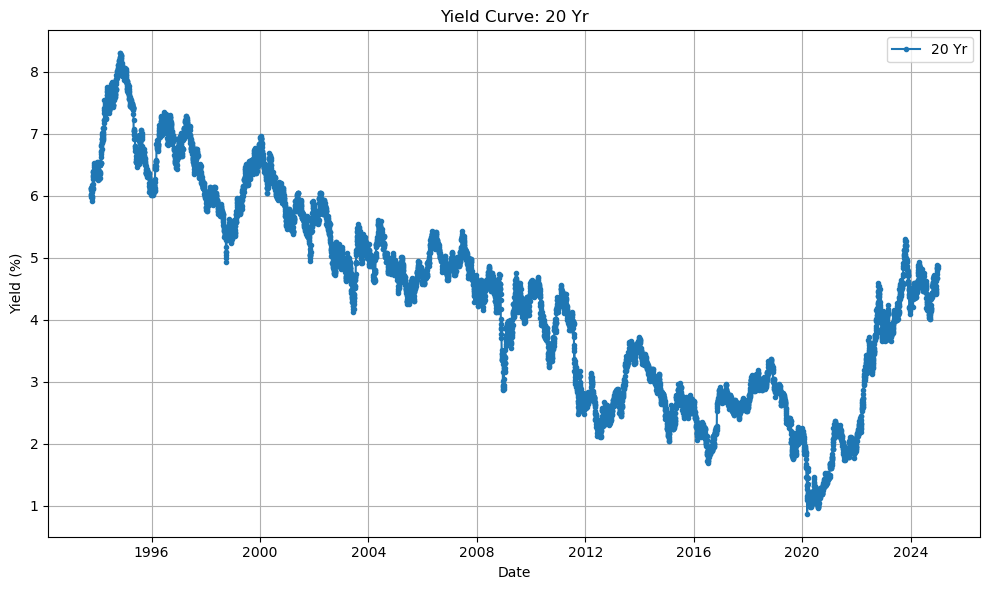

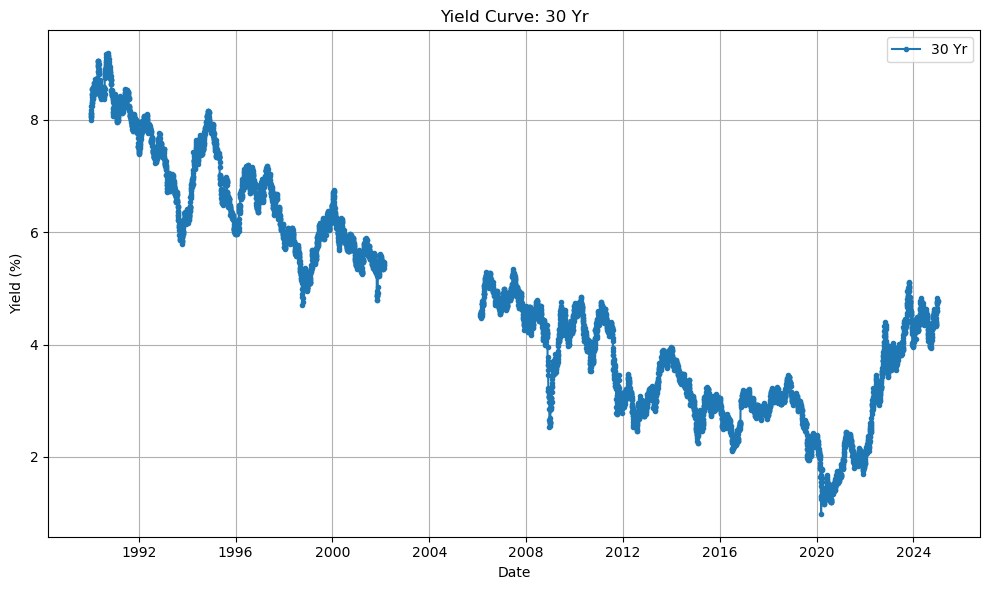

In [224]:
# Read the CSV file (adjust the path if necessary)
df = pd.read_csv('yield-curve-rates-1990-2024.csv', parse_dates=['Date'])

# List of term columns (assuming "Date" is the only non-yield column)
term_columns = [col for col in df.columns if col != 'Date']

# Create a separate graph for each term structure
for term in term_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df[term], marker='.', linestyle='-', label=term)
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.title(f'Yield Curve: {term}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Displays the graph; for batch processing, you might want to save figures instead.


In [225]:
# Check for missing values in the '1 Mo' column
print(df['1 Mo'].isnull().sum())

# Check if there are any infinite values (rare, but good to check)
print(np.isinf(df['1 Mo']).sum())


2900
0


In [226]:
# Remove rows where '1 Mo' is missing
df = df.dropna(subset=['1 Mo'])

# Sort the DataFrame by date (oldest first) to get a proper time series
df.sort_values(by='Date', inplace=True)

# Extract the short rate series as a NumPy array.
# Here, we assume that each row is a trading day.
short_rates = df['1 Mo'].values

print("head")
print(df['1 Mo'].head())
print("tail")
print(df['1 Mo'].tail())
print(df['1 Mo'].dtype)


head
5857    3.67
5856    3.65
5855    3.65
5854    3.63
5853    3.62
Name: 1 Mo, dtype: float64
tail
4    4.44
3    4.45
2    4.44
1    4.43
0    4.40
Name: 1 Mo, dtype: float64
float64


In [227]:
# Override theta: set it equal to the historical mean of the short rate.
theta_est = np.mean(short_rates)
print(theta_est)

1.5524654259859996


# The Vasicek Model

The **Vasicek model** is a one-factor interest rate model that describes the evolution of the short rate *rt* as a mean-reverting process. Its dynamics are governed by the stochastic differential equation (SDE):

$$
dr_t = K (\theta - r_t) \, dt + \sigma \, dW_t,
$$

where:

$$
\text{- }\, r_t \text{ is the short-term interest rate at time } t.
$$

$$
\text{- }\, K \text{ is the speed of mean reversion. A higher } K \text{ means the rate reverts more quickly to its long-term mean.}
$$

$$
\text{- }\, \theta \text{ is the long-term mean rate toward which the process reverts.}
$$

$$
\text{- }\, \sigma \text{ is the volatility of the interest rate, representing the magnitude of random fluctuations.}
$$

$$
\text{- }\, dW_t \text{ is a Wiener process (or Brownian motion) that introduces randomness.}
$$


OLS Regression Results (Full Sample):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.598e+06
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:44:48   Log-Likelihood:                 7804.7
No. Observations:                5856   AIC:                        -1.561e+04
Df Residuals:                    5854   BIC:                        -1.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

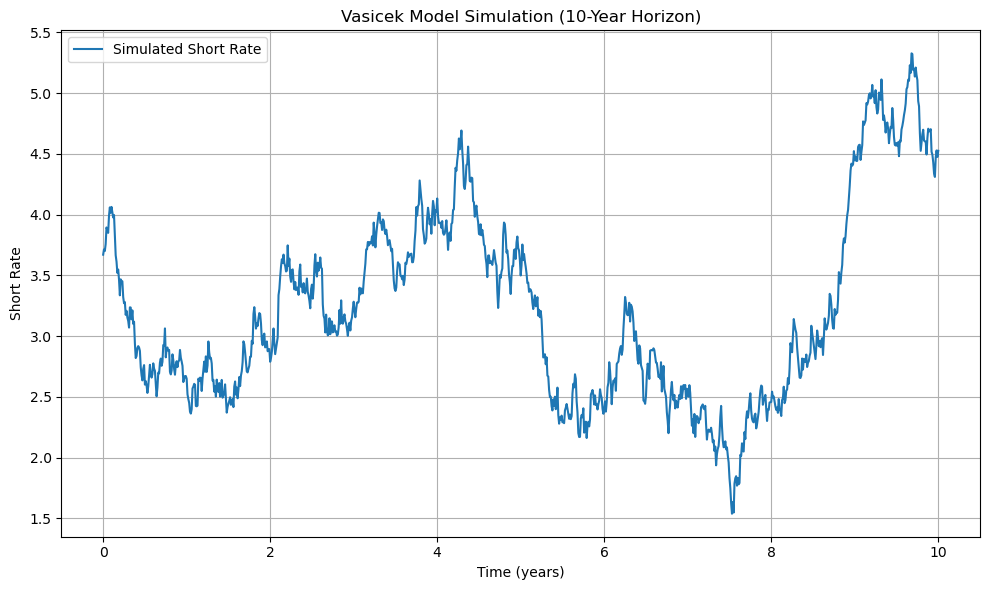

In [228]:
# ===============================
# Vasicek Calibration & Simulation
# ===============================

# ---- Calibration using the full historical data (daily series) ----

# Create daily r_t and r_{t+dt} series.
r_t = short_rates[:-1]
r_tp = short_rates[1:]

# Run the OLS regression: r_{t+dt} = A + B * r_t + error.
X = sm.add_constant(r_t)
model = sm.OLS(r_tp, X)
results = model.fit()
A_est, B_est = results.params  # A_est: intercept, B_est: slope

# Print the full OLS regression summary.
print("OLS Regression Results (Full Sample):")
print(results.summary())

# Recover the speed of mean reversion using daily data:
K_est = (1 - B_est) / dt

# Override theta: set it equal to the historical mean of the short rate.
theta_est = np.mean(short_rates)

# ---- Estimate volatility using weekly differences ----
# Form a weekly series by taking every 5th observation.
weekly_rates = short_rates[::5]
dt_week = 5 / 252.0  # weekly time step
d_week = np.diff(weekly_rates)
# Estimate sigma using the moment condition for the weekly changes:
sigma_est = np.std(d_week, ddof=1) / np.sqrt(dt_week)

# Set the initial short rate (for simulation, we use the first observed rate;
# in backtesting, we'll update this to the latest rate).
r0_est = short_rates[0]

# Print the calibrated Vasicek parameters.
print("\nEstimated Vasicek Parameters (Full Sample Calibration):")
print(f"Initial Rate (r0): {r0_est:.4f}")
print(f"Speed of Mean Reversion (K): {K_est:.4f}")
print(f"Long-term Mean (theta): {theta_est:.4f}")
print(f"Volatility (sigma): {sigma_est:.4f}")

# ---- Simulate the Vasicek Process over a 10-Year Horizon ----
T = 10  # total time in years
N = int(T / dt)
times = np.linspace(0, T, N + 1)
sim_rates = np.zeros(N + 1)
sim_rates[0] = r0_est

np.random.seed(42)  # for reproducibility

for i in range(N):
    dW = np.random.normal(0, np.sqrt(dt))
    sim_rates[i + 1] = sim_rates[i] + K_est * (theta_est - sim_rates[i]) * dt + sigma_est * dW

plt.figure(figsize=(10, 6))
plt.plot(times, sim_rates, label="Simulated Short Rate")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.title("Vasicek Model Simulation (10-Year Horizon)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


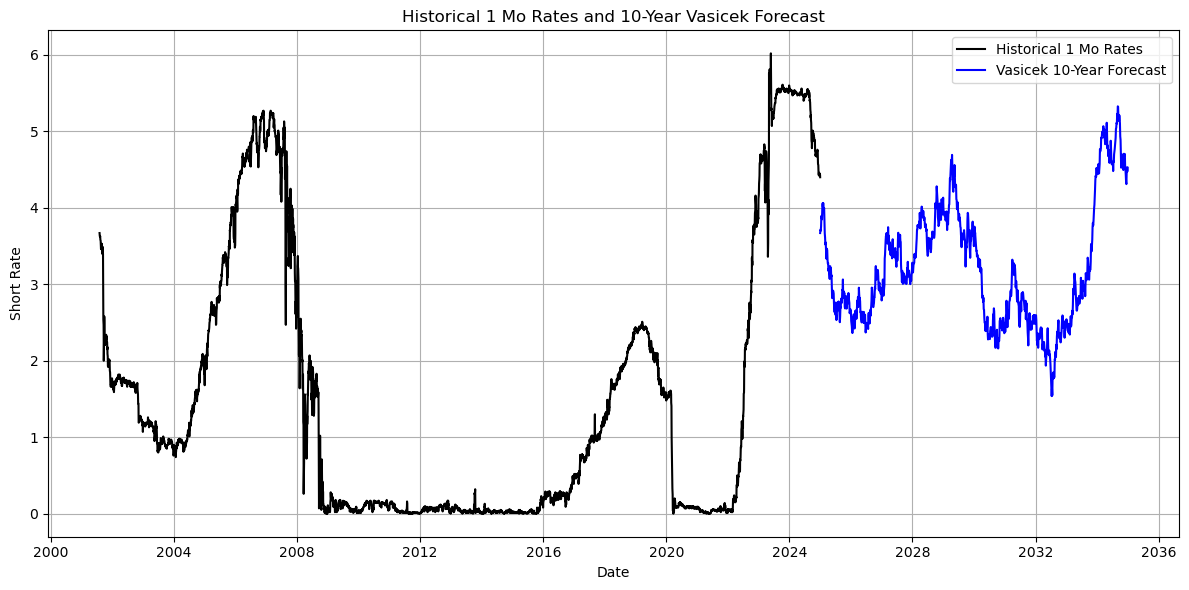

In [229]:
# ===============================
# Real plus Vasicek Forecast
# ===============================

last_date = df['Date'].iloc[-1]

# Convert simulation "years" into calendar days (assuming 365 days/year)
forecast_dates = [last_date + pd.Timedelta(days=t*365) for t in times]

# --- Plot historical data and simulation forecast together ---

plt.figure(figsize=(12, 6))

# Plot historical "1 Mo" rates (black line)
plt.plot(df['Date'], short_rates, color='black', label="Historical 1 Mo Rates")

# Plot the Vasicek 10-year simulation forecast (blue line)
plt.plot(forecast_dates, sim_rates, color='blue', label="Vasicek 10-Year Forecast")

plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.title("Historical 1 Mo Rates and 10-Year Vasicek Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Explanation

**Vasicek** and **CIR** are both one-factor interest rate models with mean reversion. The main differences are:

- **Vasicek Model:** Uses a constant volatility term, so its diffusion component is given by 
$$
\sigma \, dW_t.
$$

- **CIR Model:** Uses a state-dependent volatility term, so its diffusion component is given by 
$$
\sigma \sqrt{r_t} \, dW_t.
$$  
This feature helps ensure non-negativity of rates, whereas the Hull–White (and Vasicek) model can produce negative rates.

In our calibration, we estimate the speed of mean reversion and volatility using an OLS regression on daily data and weekly differences (to capture realistic variability). We override *theta* with the historical mean and set the initial rate *r0* to the latest observed rate so that the simulated path starts at the actual market rate on 12/31/2024.


OLS Regression Results (Full Sample):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.598e+06
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:44:48   Log-Likelihood:                 7804.7
No. Observations:                5856   AIC:                        -1.561e+04
Df Residuals:                    5854   BIC:                        -1.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

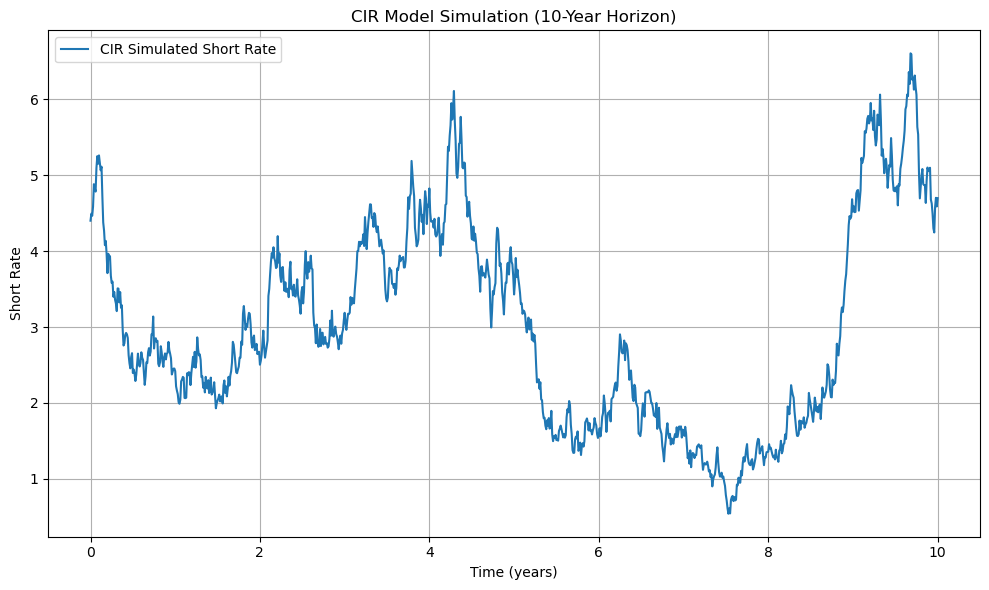

In [230]:
# ===============================
# CIR Calibration & Simulation
# ===============================

# ---- Calibration using the full historical data (daily series) ----

# Create daily r_t and r_{t+dt} series from the historical "1 Mo" rates.
r_t = short_rates[:-1]
r_tp = short_rates[1:]

# Run the OLS regression: r_{t+dt} = A + B * r_t + error.
X = sm.add_constant(r_t)
model = sm.OLS(r_tp, X)
results = model.fit()
A_est, B_est = results.params  # A_est: intercept, B_est: slope

# Print the full OLS regression summary.
print("OLS Regression Results (Full Sample):")
print(results.summary())

# Recover the speed of mean reversion using daily data:
K_est = (1 - B_est) / dt

# Override theta: set it equal to the historical mean of the short rate.
# (This is the same as for Vasicek.)
theta_est = np.mean(short_rates)

# ---- Estimate volatility using weekly differences ----
# Form a weekly series by taking every 5th observation.
weekly_rates = short_rates[::5]
dt_week = 5 / 252.0  # weekly time step
d_week = np.diff(weekly_rates)
# For consistency with your Vasicek approach, estimate sigma as:
sigma_est_cir = np.std(d_week, ddof=1) / np.sqrt(dt_week)

# Override r0 to be the latest observed rate (e.g. 12/31/2024).
r0_est = short_rates[-1]

# Print the calibrated CIR parameters.
print("\nEstimated CIR Parameters (Full Sample Calibration):")
print(f"Initial Rate (r0): {r0_est:.4f}")
print(f"Speed of Mean Reversion (K): {K_est:.4f}")
print(f"Long-term Mean (theta): {theta_est:.4f}")
print(f"Volatility (sigma): {sigma_est_cir:.4f}")

# ---- Define the CIR Simulation Function ----
def cir_simulation(r0, K, theta, sigma, T, dt):

    num_steps = int(T / dt)
    rates = np.zeros(num_steps + 1)
    rates[0] = r0
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        # Euler discretization for CIR:
        # r(t+dt) = r(t) + K*(theta - r(t))*dt + sigma*sqrt(max(r(t), 0))*sqrt(dt)*dW
        dr = K * (theta - rates[t-1]) * dt + sigma * np.sqrt(max(rates[t-1], 0)) * dW
        rates[t] = max(0, rates[t-1] + dr)
    return rates

# ---- Simulation ----
# Simulate the CIR process over a 10-year horizon:
T = 10  # total time in years
num_steps = int(T / dt)
times = np.linspace(0, T, num_steps + 1)

np.random.seed(42)  # for reproducibility
rates_cir = cir_simulation(r0_est, K_est, theta_est, sigma_est_cir, T, dt)

plt.figure(figsize=(10, 6))
plt.plot(times, rates_cir, label='CIR Simulated Short Rate')
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.title("CIR Model Simulation (10-Year Horizon)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

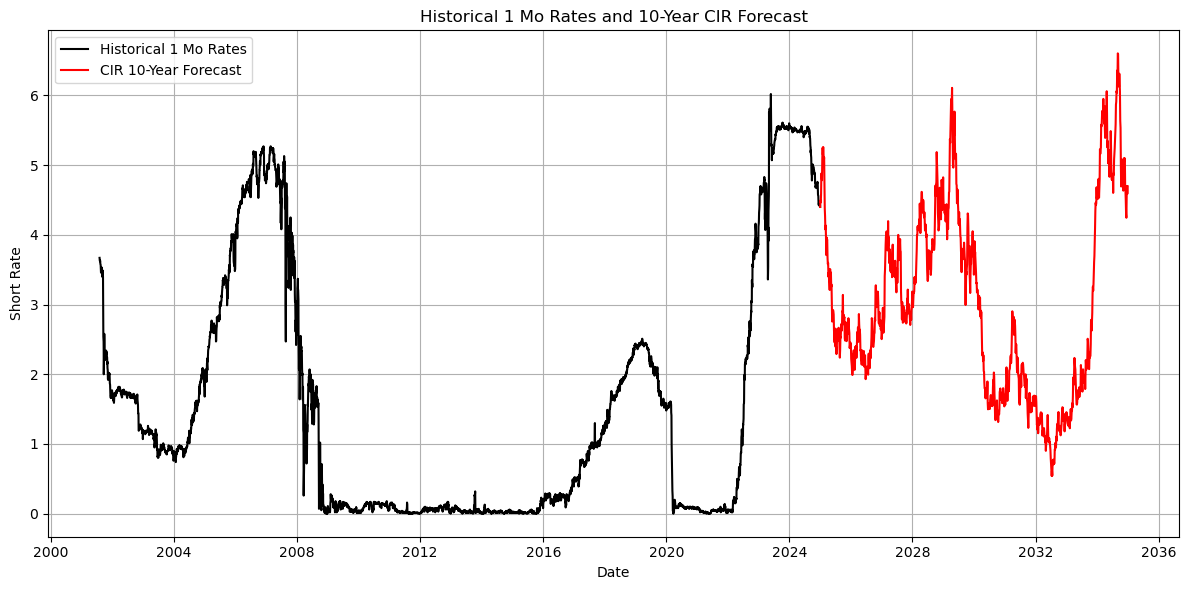

In [231]:
# ===============================
# Real plus CIR Forecast
# ===============================

last_date = df['Date'].iloc[-1]

# Convert simulation "years" into calendar days (assuming 365 days/year)
forecast_dates = [last_date + pd.Timedelta(days=t*365) for t in times]

# --- Plot historical data and simulation forecast together ---

plt.figure(figsize=(12, 6))

# Plot historical "1 Mo" rates (black line)
plt.plot(df['Date'], short_rates, color='black', label="Historical 1 Mo Rates")

# Plot the CIR 10-year simulation forecast (blue line)
plt.plot(forecast_dates, rates_cir, color='red', label="CIR 10-Year Forecast")

plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.title("Historical 1 Mo Rates and 10-Year CIR Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# The Hull–White Model with Time-Dependent Drift

The **Hull–White model** is an extension of the Vasicek model that allows for a time-dependent drift term. In its constant-parameter form with time-dependent drift, the model is written as:

$$
dr_t = a \left(\theta(t) - r_t\right) \, dt + \sigma \, dW_t,
$$

where:

$$
\text{- }\, r_t \text{ is the short-term interest rate at time } t,
$$

$$
\text{- }\, a \text{ is the speed of mean reversion (i.e., how quickly the rate reverts to its long-term mean)},
$$

$$
\text{- }\, \theta(t) \text{ is the time-dependent long-term mean, defined as } \theta(t) = \theta_{hw} + c\,t,
$$

$$
\text{- }\, \sigma \text{ is the constant volatility, and}
$$

$$
\text{- }\, dW_t \text{ is the increment of a Wiener process (Brownian motion)}.
$$

---

### Key Differences from Other Models

- **Vasicek Model:**  
  Uses a constant volatility term, so its diffusion component is given by  
  $$
  \sigma \, dW_t.
  $$  
  Its drift is given by *K(theta - rt)* with a constant *theta*.

- **CIR Model:**  
  Uses a state-dependent volatility term, so its diffusion component is given by  
  $$
  \sigma \sqrt{r_t} \, dW_t,
  $$  
  which helps ensure non-negativity of rates.

- **Hull–White Model with Time-Dependent Drift:**  
  In our version, the drift term is  
  $$
  a \left(\theta(t) - r_t\right),
  $$  
  where  
  $$
  \theta(t) = \theta_{hw} + c\,t.
  $$  
  This allows the long-term mean to evolve over time, capturing trends in the data.

---

In our calibration, we estimate the speed of mean reversion *a* and volatility *sigma* using an OLS regression on daily data and weekly differences (to capture realistic variability). We set the base long-term mean *theta{hw}* equal to the historical mean of the data and determine the trend coefficient *c* from the observed trend. We also set the initial rate *r0* to the latest observed rate so that the simulation starts at the actual market rate on 12/31/2024.


In [232]:
# ===============================
# Time Dependent Drift for Theta
# ===============================

# Create a time variable in years relative to the first date.
df['Time'] = (df['Date'] - df['Date'].iloc[0]).dt.days / 365

# Prepare the independent variable (Time) with a constant.
X = sm.add_constant(df['Time'])
y = df['1 Mo']

# Run an OLS regression: y = constant + c * Time.
model_trend = sm.OLS(y, X)
results_trend = model_trend.fit()

# The coefficient for Time is our estimate for c.
c_est = results_trend.params['Time']

print("Estimated trend (c):", c_est)

Estimated trend (c): 0.01716848852682422


OLS Regression Results (Hull-White Calibration):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.598e+06
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:44:49   Log-Likelihood:                 7804.7
No. Observations:                5856   AIC:                        -1.561e+04
Df Residuals:                    5854   BIC:                        -1.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

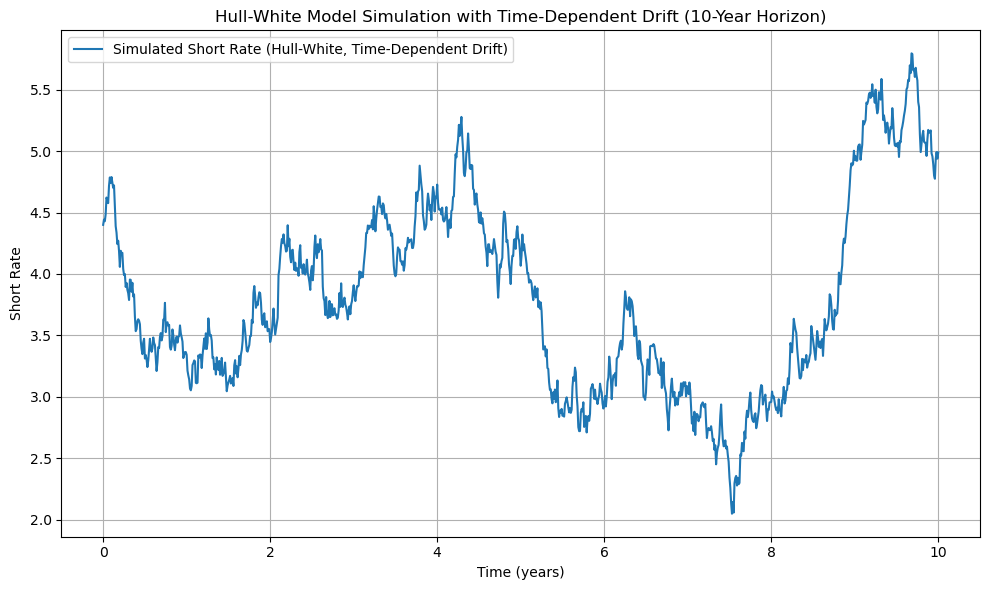

In [233]:
# ===============================
# Hull–White Calibration & Simulation (Time-Dependent Drift)
# ===============================

# ---- Calibration using the full historical data (daily series) ----

# Create daily r_t and r_{t+dt} series from historical "1 Mo" rates.
r_t_hw = short_rates[:-1]
r_tp_hw = short_rates[1:]

# Run the OLS regression: r_{t+dt} = A_hw + B_hw * r_t_hw + error.
X_hw = sm.add_constant(r_t_hw)
model_hw = sm.OLS(r_tp_hw, X_hw)
results_hw = model_hw.fit()
A_hw, B_hw = results_hw.params  # A_hw: intercept, B_hw: slope

# Print the full OLS regression summary.
print("OLS Regression Results (Hull-White Calibration):")
print(results_hw.summary())

# Recover the speed of mean reversion for Hull–White using daily data:
a_hw = (1 - B_hw) / dt

# Override theta: set the base long-term mean equal to the historical mean.
theta_hw = np.mean(short_rates)

# ---- Estimate volatility using weekly differences ----
# Form a weekly series by taking every 5th observation.
weekly_hw = short_rates[::5]
dt_week = 5 / 252.0  # weekly time step
d_week_hw = np.diff(weekly_hw)
# Estimate sigma using the moment condition for weekly changes.
sigma_hw = np.std(d_week_hw, ddof=1) / np.sqrt(dt_week)

# Override r0 to be the latest observed rate (e.g., on 12/31/2024).
r0_hw = short_rates[-1]

# Print the calibrated Hull–White parameters.
print("\nEstimated Hull–White Parameters (Full Sample Calibration):")
print(f"Initial Rate (r0): {r0_hw:.4f}")
print(f"Speed of Mean Reversion (a): {a_hw:.4f}")
print(f"Base Long-term Mean (theta_hw): {theta_hw:.4f}")
print(f"Volatility (sigma): {sigma_hw:.4f}")

# ---- Define the Time-Dependent Theta Function ----
def theta_hw_func(t):
    # For illustration, assume a linear time dependency:
    # theta(t) = theta_hw + c * t, where c is a constant (e.g., 0.0005).
    c = c_est
    return theta_hw + c * t

# ---- Define the Hull–White Simulation Function with Time-Dependent Drift ----
def hw_simulation_td(r0, a, theta_func, sigma, T, dt):

    num_steps = int(T / dt)
    times = np.linspace(0, T, num_steps + 1)
    rates = np.zeros(num_steps + 1)
    rates[0] = r0
    for i in range(1, num_steps + 1):
        t_current = times[i-1]
        theta_current = theta_func(t_current)
        dW = np.random.normal(0, np.sqrt(dt))
        dr = a * (theta_current - rates[i-1]) * dt + sigma * dW
        rates[i] = rates[i-1] + dr
    return times, rates

# ---- Simulation ----
T = 10  # total time in years
np.random.seed(42)  # for reproducibility
times_td, rates_hw_td = hw_simulation_td(r0_hw, a_hw, theta_hw_func, sigma_hw, T, dt)

plt.figure(figsize=(10, 6))
plt.plot(times_td, rates_hw_td, label="Simulated Short Rate (Hull-White, Time-Dependent Drift)")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.title("Hull-White Model Simulation with Time-Dependent Drift (10-Year Horizon)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


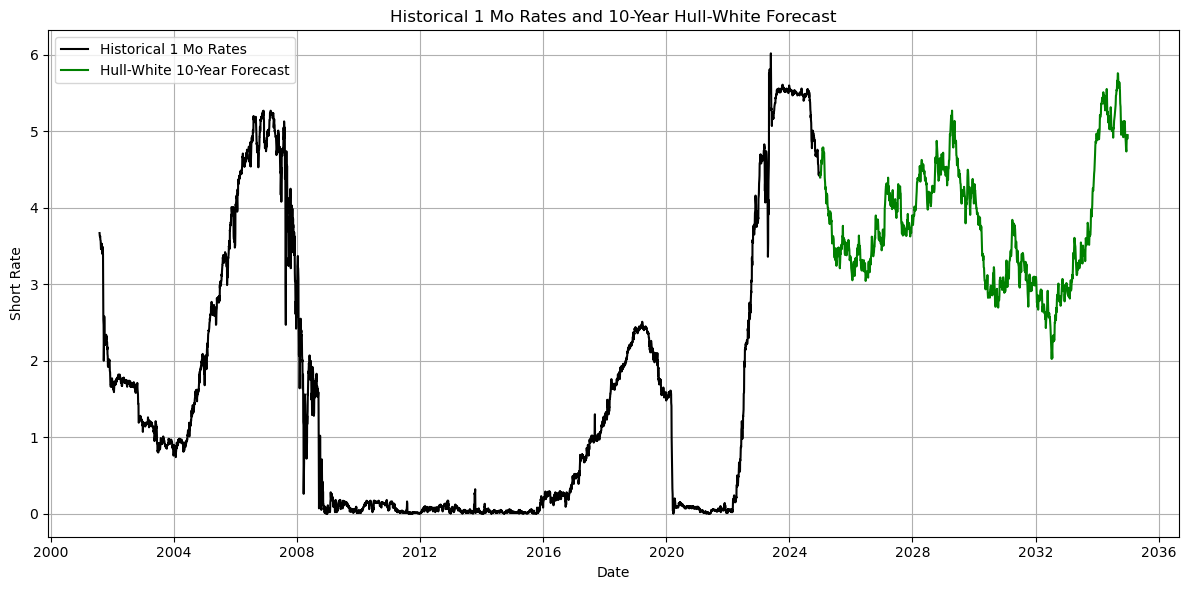

In [234]:
# Get the last historical date from the DataFrame.
last_date = df['Date'].iloc[-1]

# Convert simulation "years" into forecast dates (using 365 days/year)
forecast_dates_hw = [last_date + pd.Timedelta(days=t*365) for t in times_hw]

plt.figure(figsize=(12, 6))

# Plot historical "1 Mo" rates (black line).
plt.plot(df['Date'], short_rates, color='black', label="Historical 1 Mo Rates")

# Plot the Hull-White 10-year forecast (green line).
plt.plot(forecast_dates_hw, rates_hw, color='green', label="Hull-White 10-Year Forecast")

plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.title("Historical 1 Mo Rates and 10-Year Hull-White Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparison of Interest Rate Models: Vasicek, CIR, and Hull–White

The **Vasicek**, **CIR**, and **Hull–White** models are all one-factor models for interest rates that incorporate mean reversion, but they differ primarily in how they handle volatility:

1. **Vasicek Model**
   - **SDE:**  
     $$
     dr_t = K(\theta - r_t) \, dt + \sigma \, dW_t
     $$
   - **Volatility:** Constant (i.e., *sigma* is independent of *rt*).
   - **Pros:**  
     - Analytical tractability (closed-form solutions for bonds and options).
   - **Cons:**  
     - May produce negative interest rates.

2. **CIR Model**
   - **SDE:**  
     $$
     dr_t = K(\theta - r_t) \, dt + \sigma \sqrt{r_t} \, dW_t
     $$
   - **Volatility:** State-dependent (volatility scales with *sqrt{rt}*, which helps ensure non-negativity).
   - **Pros:**  
     - Ensures non-negative rates.
   - **Cons:**  
     - More complex calibration and dynamics.

3. **Hull–White Model**
   - **SDE (constant-parameter version):**  
     $$
     dr_t = a(\theta - r_t) \, dt + \sigma \, dW_t
     $$
   - **Volatility:** Constant, similar to Vasicek; however, the model is flexible and can incorporate time-dependent parameters.
   - **Pros:**  
     - Flexible enough to fit the initial term structure.
     - Analytical tractability for many derivatives.
   - **Cons:**  
     - Like Vasicek, can produce negative rates if not carefully calibrated.

**Improvements:**
- The **CIR model** improves upon Vasicek by using state-dependent volatility to help keep rates non-negative.
- The **Hull–White model** improves flexibility, allowing for a better fit of the initial yield curve, while maintaining many analytical advantages.


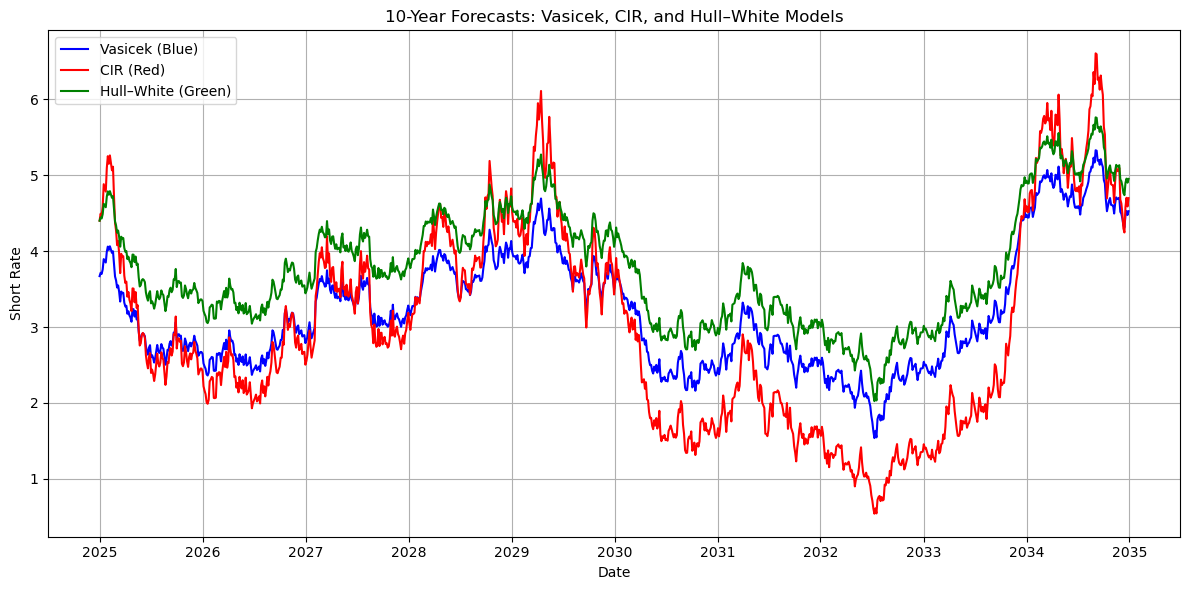

In [235]:
# Get the last observed date from the historical data:
last_date = df['Date'].iloc[-1]

# Create forecast dates for the simulation horizon.
# We'll assume 365 days per year for calendar conversion.
forecast_dates = [last_date + pd.Timedelta(days=t*365) for t in times]

plt.figure(figsize=(12, 6))

# Plot Vasicek simulation (blue)
plt.plot(forecast_dates, sim_rates, color='blue', label="Vasicek (Blue)")

# Plot CIR simulation (red)
plt.plot(forecast_dates, rates_cir, color='red', label="CIR (Red)")

# Plot Hull–White simulation (green)
plt.plot(forecast_dates, rates_hw, color='green', label="Hull–White (Green)")

plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.title("10-Year Forecasts: Vasicek, CIR, and Hull–White Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


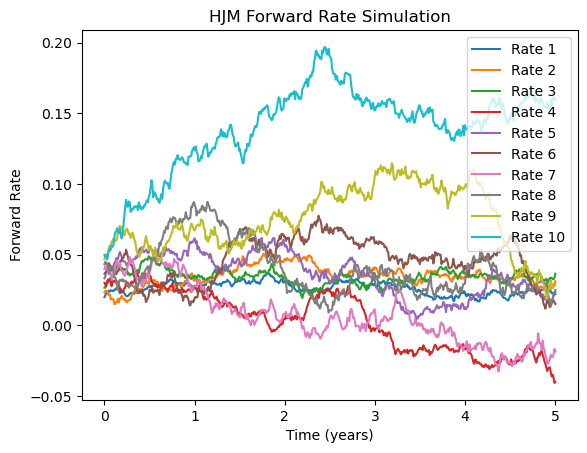

In [236]:
def hjm_forward_rate_simulation(forward_rates, volatilities, T, dt):
    """ A very simplified HJM forward rate simulation.
    forward_rates : array : initial forward rates
    volatilities : array : volatilities for each rate
    """
    num_steps = int(T / dt)
    num_rates = len(forward_rates)
    rate_paths = np.zeros((num_rates, num_steps))
    rate_paths[:, 0] = forward_rates

    for t in range(1, num_steps):
        dW = np.random.normal(size=num_rates) * np.sqrt(dt)  # Brownian increments
        drift = -0.5 * volatilities**2 * dt  # Simplified drift term
        diffusion = volatilities * dW
        rate_paths[:, t] = rate_paths[:, t-1] + drift + diffusion

    return rate_paths

# Example usage
forward_rates = np.linspace(0.02, 0.05, 10)  # 10 different forward rates from 2% to 5%
volatilities = np.linspace(0.01, 0.03, 10)  # increasing volatility
T = 5  # 5 years
dt = 0.01  # time step

rate_paths = hjm_forward_rate_simulation(forward_rates, volatilities, T, dt)

# Plotting
for i in range(len(forward_rates)):
    plt.plot(np.linspace(0, T, int(T/dt)), rate_paths[i, :], label=f'Rate {i+1}')
plt.title('HJM Forward Rate Simulation')
plt.xlabel('Time (years)')
plt.ylabel('Forward Rate')
plt.legend()
plt.show()


In [237]:
import numpy as np

def jump_diffusion_model(r0, K, theta, sigma, lambda_j, mu_j, sigma_j, T, dt):
    """ Simulate interest rate path with jumps.
    lambda_j : float : jump frequency per year
    mu_j : float : average jump size
    sigma_j : float : jump size volatility
    """
    num_steps = int(T / dt)
    rates = np.zeros(num_steps)
    rates[0] = r0
    for t in range(1, num_steps):
        jump = 0
        if np.random.rand() < lambda_j * dt:
            jump = np.random.normal(mu_j, sigma_j)
        dr = K * (theta - rates[t-1]) * dt + sigma * np.random.normal() * np.sqrt(dt) + jump
        rates[t] = rates[t-1] + dr
    return rates


In [238]:
# This is a conceptual representation. Actual implementation will depend on your specific model and data.
def bayesian_update(prior, likelihood, data):
    """
    Update the model's parameters using Bayesian inference.
    """
    posterior = (likelihood * data) / prior  # Simplified update rule
    return posterior


In [239]:
from sklearn.mixture import GaussianMixture

def fit_gaussian_mixture(data, components):
    model = GaussianMixture(n_components=components)
    model.fit(data.reshape(-1, 1))
    return model


In [240]:
from statsmodels.tsa.arima.model import ARIMA

def autoregressive_model(data, order):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    return model_fit


In [241]:
def monte_carlo_simulation(start_price, mu, sigma, T, dt, scenarios):
    num_steps = int(T / dt)
    results = np.zeros((scenarios, num_steps))
    for s in range(scenarios):
        prices = np.zeros(num_steps)
        prices[0] = start_price
        for t in range(1, num_steps):
            prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.random.normal() * np.sqrt(dt))
        results[s] = prices
    return results


In [242]:
def markov_chain(states, transition_matrix, steps):
    current_state = np.random.choice(states)
    history = [current_state]
    for _ in range(steps):
        current_state = np.random.choice(states, p=transition_matrix[current_state])
        history.append(current_state)
    return history


In [243]:
def price_bond(face_value, coupon_rate, market_rate, periods):
    """
    Calculates the price of a traditional fixed-coupon bond using Discounted Cash Flow (DCF).
    
    Parameters:
    face_value (float): The bond's face value (e.g., 1000)
    coupon_rate (float): The bond's coupon rate (as a decimal, e.g., 0.05 for 5%)
    market_rate (float): The current market discount rate (as a decimal)
    periods (int): The number of periods until maturity
    
    Returns:
    float: Present value of the bond
    """
    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    final_value = face_value / (1 + market_rate) ** periods  # Discounted face value
    return np.sum(cash_flows) + final_value

# Example Parameters
face_value = 1000  # Bond face value
coupon_rate = 0.05  # 5% annual coupon
market_rate = 0.04  # Market discount rate of 4%
periods = 10  # 10 years to maturity

# Compute Bond Price
bond_price = price_bond(face_value, coupon_rate, market_rate, periods)
print(f"Traditional Bond Price: ${bond_price:.2f}")


Traditional Bond Price: $1081.11


In [244]:
def binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type=None):
    """
    Prices a bond using a binomial tree approach, allowing for call or put options.
    
    Parameters:
    face_value (float): The bond's face value
    coupon_rate (float): The bond's annual coupon rate
    up_factor (float): Upward movement factor for rates
    down_factor (float): Downward movement factor for rates
    risk_free_rate (float): Risk-free rate used for discounting
    periods (int): Number of periods for the binomial tree
    option_type (str): 'call' for callable bond, 'put' for putable bond, or None
    
    Returns:
    float: Price of the bond considering the binomial tree and embedded option (if any)
    """
    # Initialize tree with terminal bond values
    bond_tree = np.zeros((periods + 1, periods + 1))

    # Calculate future bond values at maturity
    for i in range(periods + 1):
        bond_tree[i, periods] = face_value + (face_value * coupon_rate)

    # Work backward through tree
    for j in range(periods - 1, -1, -1):
        for i in range(j + 1):
            expected_value = 0.5 * (bond_tree[i, j + 1] / (1 + risk_free_rate) + bond_tree[i + 1, j + 1] / (1 + risk_free_rate))

            if option_type == 'call':
                bond_tree[i, j] = min(face_value, expected_value)  # Callable bond logic
            elif option_type == 'put':
                bond_tree[i, j] = max(face_value, expected_value)  # Putable bond logic
            else:
                bond_tree[i, j] = expected_value  # Normal bond pricing

    return bond_tree[0, 0]  # Return root node value

# Example Parameters
up_factor = 1.1
down_factor = 0.9
risk_free_rate = 0.04
option_type = "call"  # Can be None, 'call', or 'put'

# Compute Bond Prices
binomial_bond_price = binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type)
print(f"Bond Price (Binomial Tree - {option_type} option): ${binomial_bond_price:.2f}")


Bond Price (Binomial Tree - call option): $702.59


In [245]:
# ==============================
# SECTION 3: DURATION & CONVEXITY CALCULATION
# ==============================

def calculate_duration(face_value, coupon_rate, market_rate, periods):
    """
    Computes Macaulay Duration and Modified Duration of a bond.
    
    Parameters:
    face_value (float): The bond's face value
    coupon_rate (float): The bond's coupon rate
    market_rate (float): The current market discount rate
    periods (int): Number of periods
    
    Returns:
    tuple: (Macaulay Duration, Modified Duration)
    """
    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    weighted_times = np.array([t * cf for t, cf in enumerate(cash_flows, 1)])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods

    macaulay_duration = np.sum(weighted_times) / bond_price
    modified_duration = macaulay_duration / (1 + market_rate)

    return macaulay_duration, modified_duration

def calculate_convexity(face_value, coupon_rate, market_rate, periods):
    """
    Computes the convexity of a bond.
    
    Parameters:
    face_value (float): The bond's face value
    coupon_rate (float): The bond's coupon rate
    market_rate (float): The current market discount rate
    periods (int): Number of periods
    
    Returns:
    float: Convexity of the bond
    """
    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    weighted_times = np.array([(t * (t + 1) * cf) for t, cf in enumerate(cash_flows, 1)])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods

    convexity = np.sum(weighted_times) / (bond_price * (1 + market_rate) ** 2)
    return convexity

# Compute Duration & Convexity
macaulay_duration, modified_duration = calculate_duration(face_value, coupon_rate, market_rate, periods)
convexity = calculate_convexity(face_value, coupon_rate, market_rate, periods)

print(f"Macaulay Duration: {macaulay_duration:.2f} years")
print(f"Modified Duration: {modified_duration:.2f} years")
print(f"Convexity: {convexity:.2f}")


Macaulay Duration: 1.94 years
Modified Duration: 1.87 years
Convexity: 13.93


In [246]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.formula.api import ols
import statsmodels.api as sm


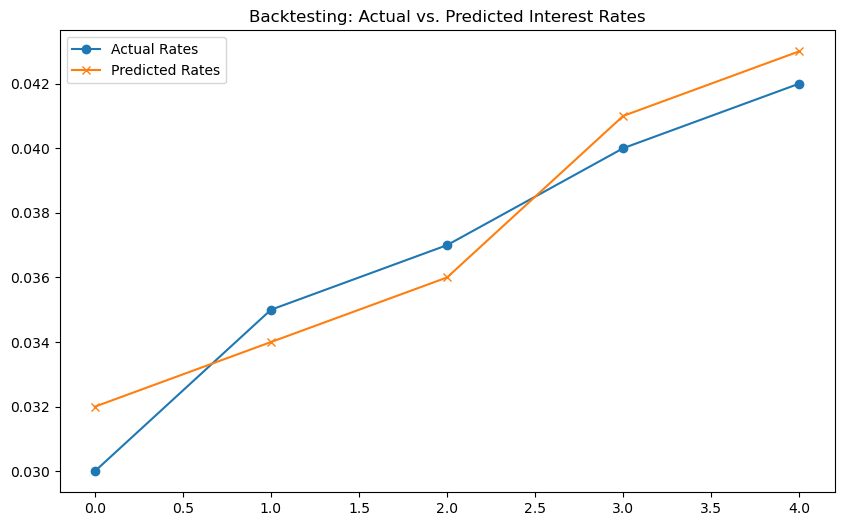

                           Metric     Value
0       Mean Absolute Error (MAE)  0.001200
1        Mean Squared Error (MSE)  0.000002
2  Root Mean Squared Error (RMSE)  0.001265


In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example Backtesting Framework
def backtest_strategy(actual_rates, predicted_rates):
    """
    Simple backtesting framework comparing actual vs. predicted rates.
    
    Parameters:
    actual_rates (array-like): Historical actual interest rates
    predicted_rates (array-like): Predicted interest rates from the model
    
    Returns:
    pd.DataFrame: Error metrics table
    """
    errors = actual_rates - predicted_rates
    
    # Calculate error metrics
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    
    # Create a DataFrame for structured results
    results_df = pd.DataFrame({
        'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [mae, mse, rmse]
    })

    # Plot actual vs predicted rates
    plt.figure(figsize=(10, 6))
    plt.plot(actual_rates, label='Actual Rates', marker='o')
    plt.plot(predicted_rates, label='Predicted Rates', marker='x')
    plt.legend()
    plt.title('Backtesting: Actual vs. Predicted Interest Rates')
    plt.show()
    
    return results_df

# Sample Data
actual_rates = np.array([0.03, 0.035, 0.037, 0.04, 0.042])
predicted_rates = np.array([0.032, 0.034, 0.036, 0.041, 0.043])

# Run Backtest
backtest_results = backtest_strategy(actual_rates, predicted_rates)
print(backtest_results)


In [248]:
def adf_test(time_series):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    
    Parameters:
    time_series (array-like): The time series data
    
    Returns:
    pd.DataFrame: ADF test results
    """
    result = adfuller(time_series)
    
    adf_results = pd.DataFrame({
        'Test Statistic': [result[0]],
        'p-value': [result[1]],
        'Critical Values': [result[4]]
    })

    return adf_results

# Sensitivity Analysis Function
def sensitivity_analysis(base_value, sensitivity_range, factor):
    """
    Perform a simple sensitivity analysis.
    
    Parameters:
    base_value (float): The initial base value (e.g., bond price)
    sensitivity_range (array-like): Range of changes (e.g., interest rate changes)
    factor (float): Sensitivity factor (e.g., modified duration)
    
    Returns:
    pd.DataFrame: Sensitivity analysis results
    """
    analysis = {'Rate Change': [], 'Adjusted Value': []}
    
    for change in sensitivity_range:
        adjusted_value = base_value * (1 + factor * change)
        analysis['Rate Change'].append(change)
        analysis['Adjusted Value'].append(adjusted_value)
    
    return pd.DataFrame(analysis)

# Run ADF Test
adf_results = adf_test(actual_rates)
print("ADF Test Results:\n", adf_results)

# Run Sensitivity Analysis
sensitivity_results = sensitivity_analysis(1000, np.linspace(-0.01, 0.01, 5), -7.5)
print("Sensitivity Analysis Results:\n", sensitivity_results)


ADF Test Results:
    Test Statistic   p-value                                    Critical Values
0       -2.199707  0.206352  {'1%': -7.355440625, '5%': -4.474365000000001,...
Sensitivity Analysis Results:
    Rate Change  Adjusted Value
0       -0.010          1075.0
1       -0.005          1037.5
2        0.000          1000.0
3        0.005           962.5
4        0.010           925.0


In [249]:
def calculate_aic_bic(time_series, lags):
    """
    Calculate AIC and BIC for model selection.
    
    Parameters:
    time_series (array-like): The time series data
    lags (int): Number of lags for the model
    
    Returns:
    pd.DataFrame: AIC and BIC values
    """
    model = sm.tsa.AutoReg(time_series, lags=lags).fit()
    
    return pd.DataFrame({
        'Model': [f'AR({lags})'],
        'AIC': [model.aic],
        'BIC': [model.bic]
    })

# ANOVA Table for Model Comparison
def anova_table(models_dict):
    """
    Creates an ANOVA-style table for comparing multiple models.
    
    Parameters:
    models_dict (dict): Dictionary where keys are model names and values are fitted models.
    
    Returns:
    pd.DataFrame: ANOVA-style table with model comparison.
    """
    model_names = []
    rss_values = []
    aic_values = []
    bic_values = []
    
    for model_name, model in models_dict.items():
        model_names.append(model_name)
        rss_values.append(np.sum(model.resid ** 2))  # Residual Sum of Squares
        aic_values.append(model.aic)
        bic_values.append(model.bic)
    
    return pd.DataFrame({
        'Model': model_names,
        'RSS': rss_values,
        'AIC': aic_values,
        'BIC': bic_values
    })

# Generate Models for Comparison
model1 = sm.tsa.AutoReg(actual_rates, lags=1).fit()
model2 = sm.tsa.AutoReg(actual_rates, lags=2).fit()

# Compare Models Using ANOVA Table
anova_results = anova_table({"AR(1)": model1, "AR(2)": model2})
print("ANOVA Model Comparison Table:\n", anova_results)


c:\Users\npwol\anaconda3\ANACONDA\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ZeroDivisionError: division by zero